In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split

## 样本不均衡问题
**分类问题的痛点。why?**
- 分类模型天生倾向于多数的类，让多数类更容易被判断正确，少数类被牺牲；
- 模型评估指标会失去意义

**为什么不采用upsampling或是downsampling来解决样本不均衡问题like LR？**
- SVM的计算速度受到样本总数的影响
- SVM决策仅仅受到决策边界的影响，而**决策边界仅受到参数C和支持向量的影响**，单纯的增大样本量，除了增加计算成本还会增加对决策边界无影响的样本点

*sol*:SCV类中的class_weight和接口fit中的sample_weight参数，通常选取一个样本来设置

**why 逻辑回归中的修正方式？**
- 逻辑回归中，参数class_weight默认为None（1：1）；当样本不均衡时：1、{"label1":weight1,"label2":weight2}输入真实样本比例；2、‘balanced'模式

- 而在SVM中，通过C来对样本不均衡问题进行调整


In [2]:
from sklearn.datasets import make_blobs

In [5]:
# 不平衡样本
class_1 = 500  # 类别1有500个样本
class_2 = 50
centers = [[0,0],[2,2]]
cluster_std =[1.5,0.9] # 样本数量多的通常松散
X,y = make_blobs(n_samples=[class_1,class_2],
                 centers = centers,
                  cluster_std = cluster_std,
                  random_state=0,shuffle=False
                 )


In [6]:
X.shape

(550, 2)

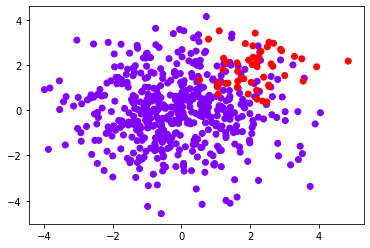

In [7]:
plt.scatter(X[:,0],X[:,1],c=y,cmap='rainbow')
plt.show()

In [8]:
# 模型1 ：不设置class_weight
clf = svm.SVC(kernel='linear', C=1)
clf.fit(X,y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [10]:
# model2: 设置class_weight
wclf = svm.SVC(kernel='linear', class_weight={1:10})
wclf.fit(X,y)

SVC(C=1.0, cache_size=200, class_weight={1: 10}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [11]:
# accuracy
clf.score(X,y)

0.9272727272727272

In [12]:
wclf.score(X,y)

0.88

<function matplotlib.pyplot.show(*args, **kw)>

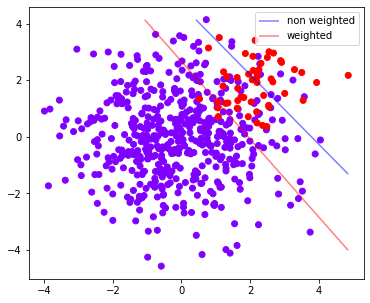

In [23]:
# why 均衡后的模型score更低？
# 绘制两个模型下的决策边界
plt.figure(figsize=(6,5))
plt.scatter(X[:,0],X[:,1],c=y,cmap='rainbow')
ax = plt.gca()

# 网格
x_min, x_max = X[:,0].min(), X[:,0].max()
y_min, y_max = X[:,1].min(), X[:,1].max()

XX,YY = np.mgrid[x_min:x_max:20j,y_min:y_max:20j]

xy = np.c_[XX.ravel(),YY.ravel()]

# 样本到决策边界的距离
Z_clf = clf.decision_function(xy).reshape(XX.shape)
a = ax.contour(XX, YY, Z_clf,colors='b',levels=[0],alpha=0.5,linestyles=['-'])

Z_wclf = wclf.decision_function(xy).reshape(XX.shape)
b = ax.contour(XX, YY, Z_wclf,colors='red',levels=[0],alpha=0.5,linestyles=['-'])

# a.collections
plt.legend([a.collections[0],b.collections[0]],['non weighted', 'weighted'],
          loc='upper right')
plt.show()

In [29]:
a.collections # 线的集合，调用这个等高线里所有线的集合
# plt.lengend([对象列表]，[图例的列表]，位置)
[*a.collections]

>尽量捕获少数类-> weighted model

### 模型评估指标
why acc不够？目标要求尽量捕获少数类，只需要对少数类的准确率的高。但是将多数类召回的成本过高，即

单纯的追求捕捉少数类，会使成本过高；但不顾及少数类，无法达成模型的效果->**捕获少数类的能力和将多数类判错后需要付出的成本**的平衡。

引入混淆矩阵和ROC曲线来帮助评估。


- 少数量的平衡艺术：P，R，F1

precision:准确率，被预测为少数类中真正少数类的比例. 
真正的红色点占被分类为红色点的样本中的比例
当每一次将多数类判断错误的成本非常高的时候(比如大众召回车辆),追求高精确度。
$$P = \frac{TP}{TP+FP}$$

In [30]:
(y[y==clf.predict(X)]==1).sum()/(clf.predict(X)==1).sum()

0.6470588235294118

In [31]:
(y[y==wclf.predict(X)]==1).sum()/(wclf.predict(X)==1).sum()

0.42727272727272725

Recall:召回率。
真正红色点中被分类为红色的比例
如果不计一切成本捕获少数类，追求高的召回
$$R = \frac{TP}{TP+FN}$$

In [32]:
(y[y==clf.predict(X)]==1).sum()/(y==1).sum()

0.44

In [33]:
(y[y==wclf.predict(X)]==1).sum()/(y==1).sum()

0.94

可以看出P和R是此消彼长的，综合采用F1来衡量,追求较高的F1
$$F1 = \frac{2*Precision*Recall}{Precision+Recall}$$

- 多数类的考量

Specificity

特异度衡量了一个模型将多数类判断正确能力，1-s为将多数类判断错误的能力，叫做假正率。
$$FPR = \frac{FP}{TN+FP}$$

In [34]:
(y[y == clf.predict(X)] == 0).sum()/(y == 0).sum()

0.976

In [36]:
(y[y == wclf.predict(X)] == 0).sum()/(y == 0).sum()

0.874

In [ ]:
from sklearn.metrics import confusion_matrix # 混淆矩阵
from sklearn.metrics import accracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve  # 精确度-召回率平衡曲线，战士不同阈值下的精确度和召回率如何变化
from sklearn.metrics import f1_score`

### Recall和FPR之间的平衡-- ROC曲线
衡量模型在尽量捕捉少数类的时候，损伤多数类的情况如何变化。

横轴：不同阈值下的FPR；纵轴：不同阈值下的Recall


- 概率和阈值

逻辑回归中 P(C1|x)=0.6,P(C2|x2)=0.4,则被分为C1。这是的阈值为0.5

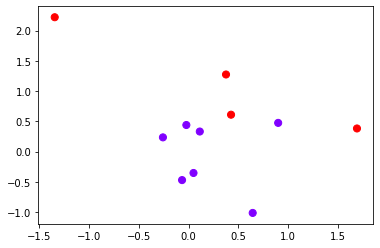

In [38]:
class_1 = 7
class_2 = 4
centers =[[0,0],[1,1]]
cluster_std=[0.5,1]
X_, y_ = make_blobs(n_samples=[class_1,class_2],
                   centers=centers,
                    cluster_std=cluster_std
                   )
plt.scatter(X_[:,0],X_[:,1],c=y_,s=50,cmap='rainbow')
plt.show()


### 以逻辑回归为例建模
重要接口clf.predict_proba(X)


In [ ]:
from sklearn.linear_model import LogisticRegression as LR

In [40]:
clf_lr = LR().fit(X_,y_)

/home/esterl/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [42]:
prob = clf_lr.predict_proba(X_)  # 似然
prob.shape

(11, 2)

In [44]:
pf = pd.DataFrame(prob)
pf.columns = ['0','1']
pf

,0,1
0,0.789273,0.210727
1,0.459954,0.540046
2,0.325423,0.674577
3,0.647191,0.352809
4,0.760646,0.239354
5,0.496155,0.503845
6,0.595273,0.404727
7,0.495891,0.504109
8,0.576822,0.423178
9,0.226021,0.773979


In [45]:
# 手动调节阈值，改变参数
for i in range(pf.shape[0]):
    if pf.loc[i,"1"] > 0.5:
        pf.loc[i,"pred"] = 1
    else:
        pf.loc[i,"pred"] = 0
        

In [47]:
#添加真实标签
pf["y_true"] = y_

In [48]:
# 根据"1"这一列来排序，不要逆序
pf = pf.sort_values(by='1',ascending=False)

In [49]:
pf

,0,1,pred,y_true
9,0.226021,0.773979,1.0,1
2,0.325423,0.674577,1.0,1
1,0.459954,0.540046,1.0,1
7,0.495891,0.504109,1.0,1
5,0.496155,0.503845,1.0,0
8,0.576822,0.423178,0.0,0
6,0.595273,0.404727,0.0,0
3,0.647191,0.352809,0.0,0
4,0.760646,0.239354,0.0,0
0,0.789273,0.210727,0.0,0


In [83]:
# 使用混淆矩阵
from sklearn.metrics import confusion_matrix as CM, precision_score as P, recall_score as R

In [62]:
CM(pf['y_true'],pf['pred'],labels=[1,0])  # 1为少数类

array([[4, 0],
       [1, 6]])

In [56]:
p=4/5
p

0.8

In [58]:
r = 4/4
r

1.0

In [67]:
P(pf['y_true'],pf['pred'],labels=[1,0])  # 1为少数类,真实值在前

0.8

In [87]:
a = R(pf['y_true'],pf['pred'],labels=[1,0])# 1为少数类
type(a)

numpy.float64

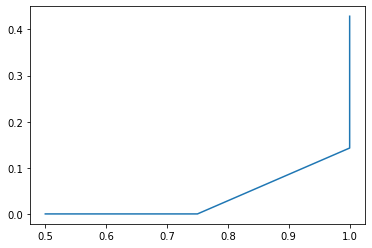

In [97]:
## 调整阈值 通常来说，降低阈值能够升高recall
pf_ = pd.DataFrame(prob)
pf_.columns = ['0','1']
pf_['y_true'] = y_
threshold = np.linspace(0.4,0.6,200)
R_l = []
FPR = []

for th in threshold:
    for i in range(pf_.shape[0]):
        if pf_.loc[i,"1"] > th:
            pf_.loc[i,'pred'] = 1
        else:
            pf_.loc[i, 'pred'] = 0
            
    R_l.append(R(pf_['y_true'], pf_['pred'], labels=[1,0]))
    cm = CM(pf_['y_true'], pf_['pred'], labels=[1,0])  # 1为少数类    
    FPR.append(cm[1,0]/cm[1,:].sum())
    
plt.plot(R_l, FPR)

一个思考：
对于决策树，支持向量机这种不依靠概率的算法，如何利用阈值来画ROC；

如果有概率需求，优先考虑LR或是Naive Bayes。不过SVM也可以生成概率

树类算法如决策树和随机森林等： 限制叶子节点的样本数可以得到概率，但在复杂数据集上才有效
数据量较少时优先考虑LR

### SVM实现概率预测：重要参数probability, 接口predict_proba以及decision_function

decision_function返回样本点距离超平面的距离，本质来说，距离符号相同时，越远离超平面的点归属于某个标签类的概率越大，故decision_function返回的值可以看作置信度。

probability设置为True，即可调用predict_proba和predict_log_proba接口。

SVC采用Platt缩放来生成概率，即在decision_function生成的距离上进行Sigmoid压缩，并附加训练数据的cross_val，生成类LR的SVM分数

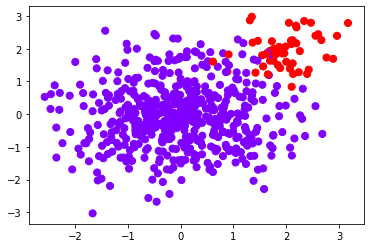

In [6]:
class_1 = 500
class_2 = 50 # 1
centers=[[0,0],[2,2]]
cluster_std=[1,0.5]
X,y = make_blobs(n_samples=[class_1, class_2]
                , centers=centers
                 , cluster_std=cluster_std
                )
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='rainbow')
plt.show()

In [15]:
clf = svm.SVC(kernel='linear', C=1, probability=True).fit(X,y) # 第二行为类别为1的概率

In [16]:
clf.predict_proba(X)

array([[9.96855101e-02, 9.00314490e-01],
       [9.99971089e-01, 2.89109068e-05],
       [9.99983201e-01, 1.67990366e-05],
       ...,
       [9.97621078e-01, 2.37892161e-03],
       [9.99938008e-01, 6.19922367e-05],
       [9.99701603e-01, 2.98396691e-04]])

In [12]:
clf.decision_function(X)[clf.decision_function(X)>0].shape  

(50,)

### 绘制ROC曲线
SVM用置信度即decision_function也可以画ROC曲线

In [14]:
from sklearn.metrics import confusion_matrix as CM, precision_score as P, recall_score as R

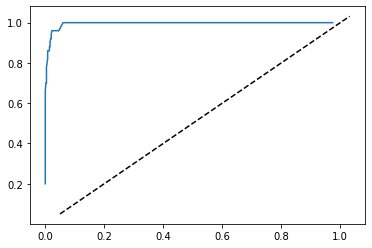

In [33]:
recall = []
FPR = []

th_range = np.linspace(clf.predict_proba(X)[:,1].min(), clf.predict_proba(X)[:,1].max(),55, endpoint=False)
# 不能取最大概率值，这是因为yuce>th_max时，返回Nan，无意义

pf = pd.DataFrame(clf.predict_proba(X))
pf.columns=['0','1']
pf['y_true'] = y

for th in th_range:
    for i in range(pf['1'].shape[0]):
        if pf.loc[i,'1'] > th:
            pf.loc[i,'pred'] = 1
        else:
            pf.loc[i,'pred'] = 0
    #recall.append(R(pf['y_true'],pf['pred'],labels=[1,0]))
    cm = CM(pf['y_true'],pf['pred'],labels=[1,0])
    recall.append(cm[0,0]/cm[0,:].sum())
    FPR.append(cm[1,0]/cm[1,:].sum())

recall.sort()
FPR.sort()
plt.plot(FPR,recall)
plt.plot(th_range+0.05,th_range+0.05,c='black',linestyle='--')
plt.show()

> 衡量ROC曲线具体的效益->AUC面积


In [41]:
from sklearn.metrics import roc_curve # 5个参数
from sklearn.metrics import roc_auc_score as AUC

In [36]:
FPR, recall, thresholds = roc_curve(pf['y_true'], clf.decision_function(X), pos_label=1)

In [37]:
FPR.shape

(22,)

In [38]:
recall.shape

(22,)

In [39]:
thresholds # decision_function返回的距离

array([ 6.05565563e+00,  5.05565563e+00,  8.86613122e-01,  8.83326677e-01,
        8.70010434e-01,  8.49324787e-01,  5.91418598e-01,  5.56291990e-01,
        4.71296847e-01,  4.41903880e-02, -5.53480711e-03, -6.04804776e-02,
       -2.62063458e-01, -3.48717570e-01, -5.22409907e-01, -5.74043539e-01,
       -5.83320338e-01, -1.39563663e+00, -1.40888909e+00, -1.45169504e+00,
       -1.45272473e+00, -1.32879347e+01])

In [49]:
area = AUC(pf['y_true'], clf.decision_function(X))
area

0.99512

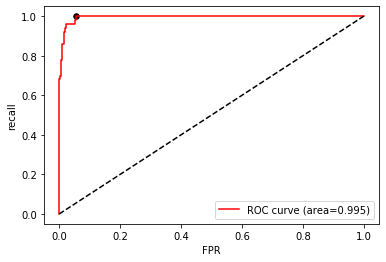

In [57]:
plt.figure()
plt.plot(FPR, recall, color='red',
        label='ROC curve (area=%.3f)'% area)
plt.plot([0,1],[0,1],color='black', linestyle='--')
plt.scatter(FPR[index],recall[index],c='black',s=30)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('FPR')
plt.ylabel('recall')
plt.legend(loc='lower right')
plt.show()

> 利用ROC曲线找出最佳阈值

recall增加时FPR如何变化，max(abs(recall-FPR)),recall和FPR差距最大的点.离虚线距离最远的点->最佳阈值。

In [55]:
index = list(recall-FPR).index(max(list(recall-FPR)))

In [56]:
thresholds[index] # decision_function生成的置信度来说

-1.4527247339705935

### SVC推广到多分类上：decision_function_shape